In [82]:
import pandas as pd
import numpy as np
import deepchem as dc
from sklearn.ensemble import RandomForestRegressor
import optuna

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
path_to_pickle = 'datasets/small_dataset1_CHEMBL1963937.pkl'

small_dataset1 = pd.read_pickle(path_to_pickle)
small_dataset1.tail()

,smiles,label
2118,COc1ccc(-c2nc3ccccc3s2)cc1,4.500000
2119,Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C3CC3c3cc...,4.450000
2120,O=C(O)C1=C(C(=O)O)C2CCC1C2,4.599999
2121,Cc1ccsc1C(=O)Nc1ccc2c(c1)OCCO2,4.550000
2122,COc1cc(OC)cc(C(=O)Nc2ccc3c(c2)OCCO3)c1,4.675000


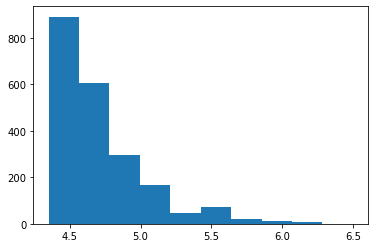

In [3]:
smiles = small_dataset1.smiles.to_numpy()
labels = np.vstack(small_dataset1.label.to_numpy())
plt.hist(labels)
plt.show()

In [4]:
featurizer = dc.feat.CircularFingerprint(radius=2, size=2048)
features = featurizer.featurize(smiles)
disk_dataset = dc.data.DiskDataset.from_numpy(X=features, y=labels, ids=smiles)

transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=disk_dataset)
disk_dataset_norm = transformer.transform(disk_dataset)

splitter = dc.splits.RandomSplitter()
train, test = splitter.train_test_split(disk_dataset_norm, frac_train=0.833333)
kfold = splitter.k_fold_split(train, k=5)

In [ ]:
for k in kfold:
    untransformed_labels = transformer.untransform(k[1].y)
    plt.hist(untransformed_labels)
    plt.show()

In [6]:
sklearn_random_forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=2, 
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, bootstrap=True, n_jobs=8, verbose=1)

In [15]:
def disk_dataset_from_pickle(path_to_pickle, featurizer, transformer):
    df = pd.read_pickle(path_to_pickle)
    smiles = df.smiles.to_numpy()
    labels = np.vstack(df.label.to_numpy())
    
    features = featurizer.featurize(smiles)
    dataset = dc.data.DiskDataset.from_numpy(X=features, y=labels, ids=smiles)
    dataset = transformer.transform(dataset)
    
    return dataset, transformer

In [16]:
ft = dc.feat.CircularFingerprint(radius=2, size=2048)
tf = dc.trans.NormalizationTransformer(transform_y=True, dataset=disk_dataset)

ds, tf = disk_dataset_from_pickle('datasets/small_dataset1_CHEMBL1963937.pkl', ft, tf)

In [19]:
def split_dataset(dataset, n_kfold, splitter):
    train, test = splitter.train_test_split(dataset, frac_train=0.8)
    kfold = splitter.k_fold_split(train, k=n_kfold)
    
    return kfold, test, train

In [47]:
sp = dc.splits.RandomSplitter()

kfold, test = split_dataset(ds, 5, sp)

In [48]:
len(kfold)

5

In [74]:
def objective(trial, kfold, transformer):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 500, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 1000, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 1000, log=True),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 100, log=True),
    }
    
    sklearn_random_forest = RandomForestRegressor(**param, n_jobs=-1)
    rf = dc.models.SklearnModel(sklearn_random_forest)
    
    mse = []
    for k in kfold:
        rf.fit(k[0])
        y_pred = rf.predict(k[1], transformers=[transformer])
        y_meas = transformer.untransform(k[1].y)
        mse.append(dc.metrics.mean_squared_error(y_meas, y_pred))
        
    return sum(mse)/len(mse)        

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, kfold, tf), n_trials=10)

In [76]:
study.best_params

{'n_estimators': 224,
 'max_depth': 27,
 'min_samples_split': 22,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 24}

In [100]:
sklearn_random_forest = RandomForestRegressor(**study.best_params, n_jobs=-1)
rf = dc.models.SklearnModel(sklearn_random_forest, model_dir='.')
rf.fit(k[0])

0.08004472703439074


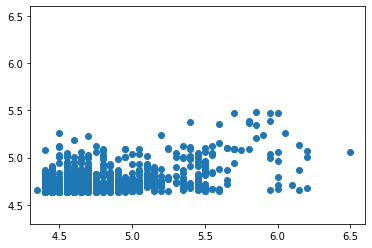

In [98]:
y_pred = rf.predict(train, transformers=[transformer])
y_meas = transformer.untransform(train.y)
print(dc.metrics.mean_squared_error(y_meas, y_pred))
plt.scatter(y_meas, y_pred)
plt.xlim([4.3, 6.6])
plt.ylim([4.3, 6.6])
plt.show()

In [101]:
rf.save()